OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [1]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b
# ...
# ...
print("contest of a: ", a)
print("contest of b: ", b)

contest of a:  [[0.4684042  0.60965044 0.72500676]
 [0.46413048 0.92862849 0.69504267]]
contest of b:  tensor([[0.4684, 0.6097, 0.7250],
        [0.4641, 0.9286, 0.6950]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [3]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[1.4535],
        [1.6693]], grad_fn=<AddBackward0>)
tensor(3.1227, grad_fn=<SumBackward0>)
tensor([[1.6920],
        [0.6202]])
tensor([[0.9765],
        [0.7415]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.

In [4]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let us examine the size of the dataset.

In [5]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?

# There are 60000 training data points and 10000 testing data points in the dataset
# For each data point, we have the image data and the actual label for this image. 
# The data size of each image is 1*28*28
# '1' means each pixel only has one channel, that's grayscale value
#'28*28' means the width and height of each image are both 28 pixels, that means each image has 28*28=784 pixels
print("the number of traning data points: ", len(trainingdata))
print("the number of testing data points: ", len(testdata))
print("the size of each data point vector: ", len(trainingdata[0]))
print("the size of each image data: ", trainingdata[0][0].size())
print("label for each data is", type(trainingdata[0][1]))

the number of traning data points:  60000
the number of testing data points:  10000
the size of each data point vector:  2
the size of each image data:  torch.Size([1, 28, 28])
label for each data is <class 'int'>


Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

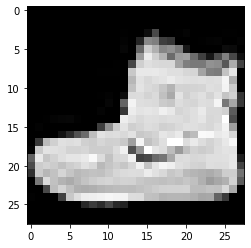

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = trainingdata[0]
# Q4.3 Assuming each sample is an image of size 28x28, show it in matplotlib.
plt.figure()
plt.imshow(image[0], cmap='gray')
plt.show()

Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches.

In [7]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([1, 4, 7, 3, 3, 7, 5, 9, 6, 7, 4, 2, 9, 0, 4, 8, 5, 5, 6, 7, 3, 7, 4, 5,
        6, 5, 0, 7, 4, 7, 5, 1, 8, 1, 3, 1, 4, 1, 3, 9, 2, 6, 9, 4, 2, 0, 6, 2,
        7, 2, 3, 6, 9, 1, 6, 8, 1, 9, 4, 2, 9, 3, 7, 3])


Showing the 10 images in one row:


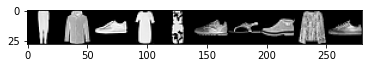

In [8]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.

first_ten_images = images[:10, 0,...].numpy()
row = np.concatenate([first_ten_images[i] for i in range(10)], axis=1)
plt.figure()
print("Showing the 10 images in one row:")
plt.imshow(row, cmap='gray')
plt.show()

Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [9]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



Cool! Now we have set everything up. Let's try to train the network.

In [10]:
train_loss_history = []
test_loss_history = []

# Q4.5 Write down a for-loop that trains this network for 20 minibatch iterations, 
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to 
# execute the next code block.

#Initiate network
net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

num_of_epochs = 20

for i in range(num_of_epochs):
  #shuffle training data 
  trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
  
  #train the net with each minibatch
  epoch_train_loss = 0
  for images, labels in trainDataLoader:
    optimizer.zero_grad()
    # calculate train loss of the current minibatch
    preds = net(images.cuda())
    batch_images_loss = Loss(preds, labels.cuda())
    epoch_train_loss += batch_images_loss

    #optimize the network
    batch_images_loss.backward()
    optimizer.step()

  # calculate train loss for the epoch
  epoch_train_loss /= len(trainingdata)
  train_loss_history.append(epoch_train_loss)

  # test the net with each minibatch
  epoch_test_loss = 0
  for images, labels in testDataLoader:
    preds = net(images.cuda())
    batch_images_loss = Loss(preds, labels.cuda())
    epoch_test_loss += batch_images_loss

  # calculate test loss for the epoch
  epoch_test_loss /= len(testdata)
  test_loss_history.append(epoch_test_loss)

  print('Epoch: {}, Train Loss: {}, Test Loss: {}'.format(i, epoch_train_loss, epoch_test_loss))


Epoch: 0, Train Loss: 0.015075350180268288, Test Loss: 0.011626826599240303
Epoch: 1, Train Loss: 0.010462744161486626, Test Loss: 0.010194201953709126
Epoch: 2, Train Loss: 0.00945297721773386, Test Loss: 0.009515694342553616
Epoch: 3, Train Loss: 0.008901090361177921, Test Loss: 0.009082348085939884
Epoch: 4, Train Loss: 0.008543850854039192, Test Loss: 0.00879995059221983
Epoch: 5, Train Loss: 0.008282531052827835, Test Loss: 0.008590555749833584
Epoch: 6, Train Loss: 0.008080583065748215, Test Loss: 0.008448470383882523
Epoch: 7, Train Loss: 0.007917402312159538, Test Loss: 0.008314765058457851
Epoch: 8, Train Loss: 0.007788826711475849, Test Loss: 0.008192445151507854
Epoch: 9, Train Loss: 0.007678619585931301, Test Loss: 0.008105852641165257
Epoch: 10, Train Loss: 0.007578817196190357, Test Loss: 0.008007315918803215
Epoch: 11, Train Loss: 0.00749558862298727, Test Loss: 0.007950210012495518
Epoch: 12, Train Loss: 0.007417677436023951, Test Loss: 0.007888328284025192
Epoch: 13, T

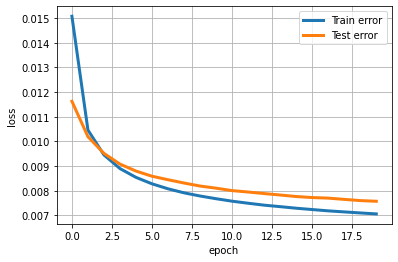

In [11]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [14]:
predicted_output = net(images.cuda())
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels.cuda())
print(labels)

torch.return_types.max(
values=tensor([ 6.1036,  2.8596,  8.8901,  7.7561,  6.7109,  6.4699, 10.3499,  4.3042,
         6.9220, 11.7484, 10.4095, 10.4313,  6.6352,  4.6126,  9.2669,  4.4923],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])


In [12]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  correct_pred = 0
  num_of_all_images = 0
  for images,labels in dataloader:
    predicted_output = net(images.cuda())
    _, predicted_labels = torch.max(predicted_output,1)
    preds_diff = labels - predicted_labels.cpu()
    correct_pred += int((preds_diff==0).sum())
    num_of_all_images += len(images)
  return correct_pred/num_of_all_images


print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))

Train acc = 0.85, test acc = 0.83
